In [1]:
import numpy as np
import pandas as pd
#from keras.models import Sequential
#from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
#from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
past_days = 40
future_days = 20
num_periods = 20

df = pd.read_csv('../datasets/A.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df_close = df['close']

C:\Users\aditya.narayanan26\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


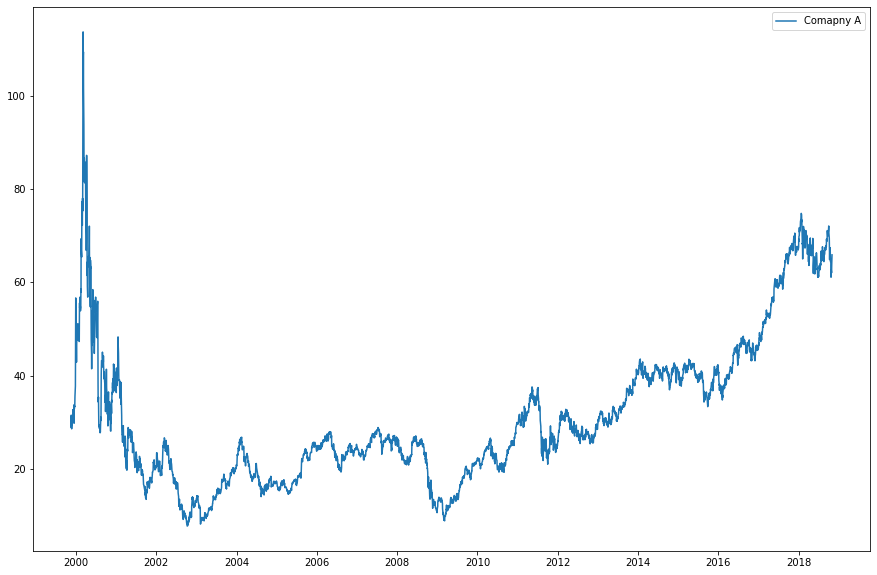

In [3]:
# Visualizations
plt.figure(figsize = (15,10))
plt.plot(df_close, label='Comapny A')
plt.legend(loc="best")
plt.show()

In [4]:
# Normalize data for predictions
data = df_close.values.reshape(df_close.shape[0], 1)
scl = MinMaxScaler()
data = scl.fit_transform(data)

In [5]:
# Allocating train and test data
div = len(data) - num_periods*future_days
train = data[:div]
test = data[div-past_days:]

In [6]:
#spliting in `n` past days as input X and `m` future days as Y.
def processData(data, prev_days, next_days,skip=1):
    X,Y = [],[]
    for i in range(0,len(data) -prev_days -next_days +1, skip):
        X.append(data[i:(i+prev_days)])
        Y.append(data[(i+prev_days):(i+prev_days+next_days)])
    return np.array(X),np.array(Y)

In [7]:
X_test,y_test = processData(test,past_days,future_days,future_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(train,past_days,future_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(3449, 40, 1)
(863, 40, 1)
(20, 40, 1)
(3449, 20)
(863, 20)
(20, 20)


In [11]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.models import load_model

In [12]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(past_days,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(future_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 3449 samples, validate on 863 samples
Epoch 1/50
 - 58s - loss: 0.0011 - val_loss: 3.6495e-04
Epoch 2/50
 - 57s - loss: 4.3318e-04 - val_loss: 9.5414e-04
Epoch 3/50
 - 57s - loss: 3.8395e-04 - val_loss: 3.1907e-04
Epoch 4/50
 - 59s - loss: 3.5362e-04 - val_loss: 0.0012
Epoch 5/50
 - 60s - loss: 3.3588e-04 - val_loss: 3.3975e-04
Epoch 6/50
 - 58s - loss: 3.1670e-04 - val_loss: 3.2368e-04
Epoch 7/50
 - 57s - loss: 3.1541e-04 - val_loss: 4.6462e-04
Epoch 8/50
 - 57s - loss: 2.9122e-04 - val_loss: 3.8204e-04
Epoch 9/50
 - 57s - loss: 2.9923e-04 - val_loss: 3.0029e-04
Epoch 10/50
 - 58s - loss: 2.9808e-04 - val_loss: 2.8792e-04
Epoch 11/50
 - 57s - loss: 2.8447e-04 - val_loss: 3.4888e-04
Epoch 12/50
 - 57s - loss: 2.8096e-04 - val_loss: 2.9528e-04
Epoch 13/50
 - 57s - loss: 2.7625e-04 - val_loss: 2.8614e-04
Epoch 14/50
 - 59s - loss: 2.8919e-04 - val_loss: 3.2687e-04
Epoch 15/50
 - 59s - loss: 2.7240e-04 - val_loss: 2.6458e-04
Epoch 16/50
 - 57s - loss: 2.6859e-04 - val_loss: 3.049

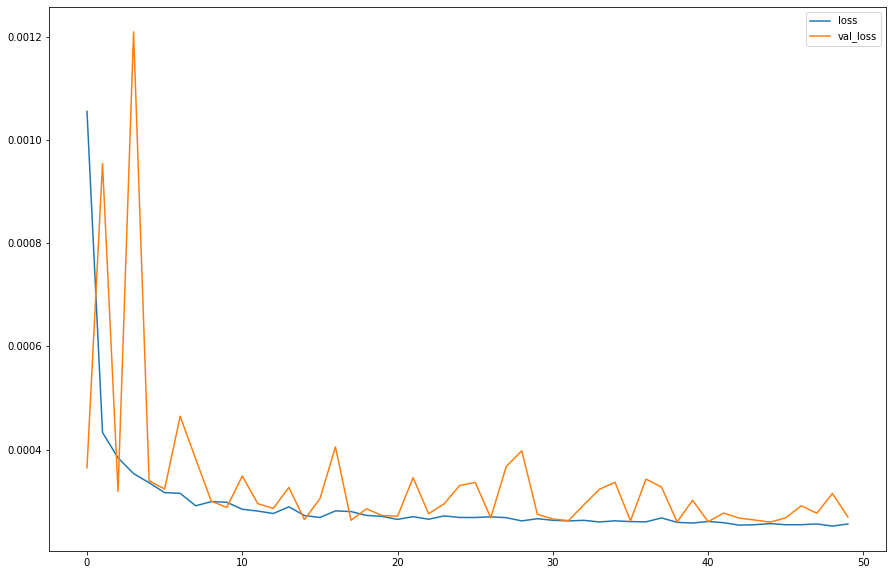

In [13]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [15]:
# Save model for future use
file_name = 'Stocksmith_LSTM_modelA_LB{}_FD{}_E{}_F{}_S{}.h5'.format(past_days, future_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))


Saved model `Stocksmith_LSTM_modelA_LB40_FD20_E50_F50_S30.h5` to disk


In [ ]:
# Here we are trying to p

In [16]:
prediction = model.predict(X_test)

In [28]:
# prediction

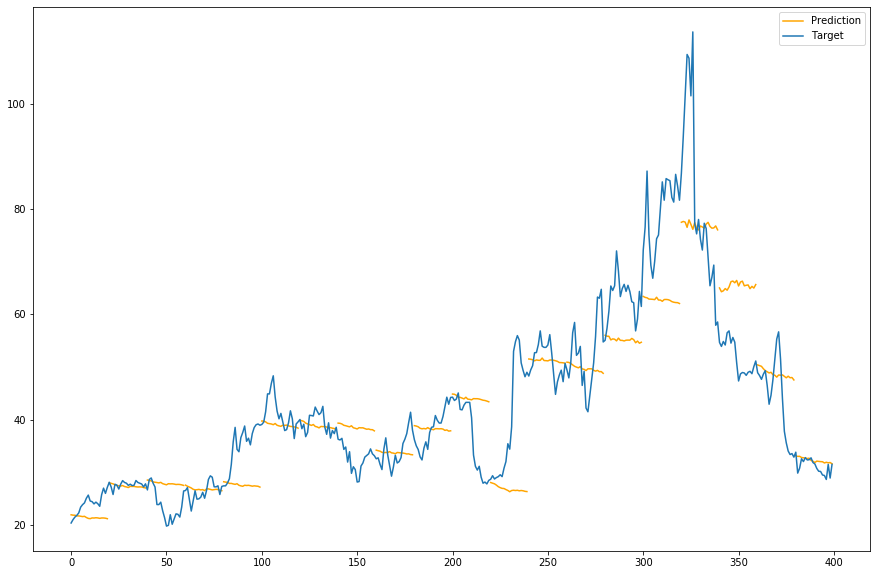

In [29]:
plt.figure(figsize = (15,10))
for i in range(0,len(prediction)):
    plt.plot([x + i*future_days for x in range(len(prediction[i]))], scl.inverse_transform(prediction[i].reshape(-1,1)), color='orange')
    
plt.plot(0, scl.inverse_transform(prediction[i].reshape(-1,1))[0], color='orange', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()